In [1]:
import sys
!{sys.executable} -m pip install opencv-python-headless
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install tensorflow


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
path_folder = "/content/gdrive/My Drive/IA/"

In [4]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow


In [5]:
data = pd.read_csv(path_folder+'fer2013/fer2013.csv')
data.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


Text(0.5, 1.0, 'Imagens x emoções')

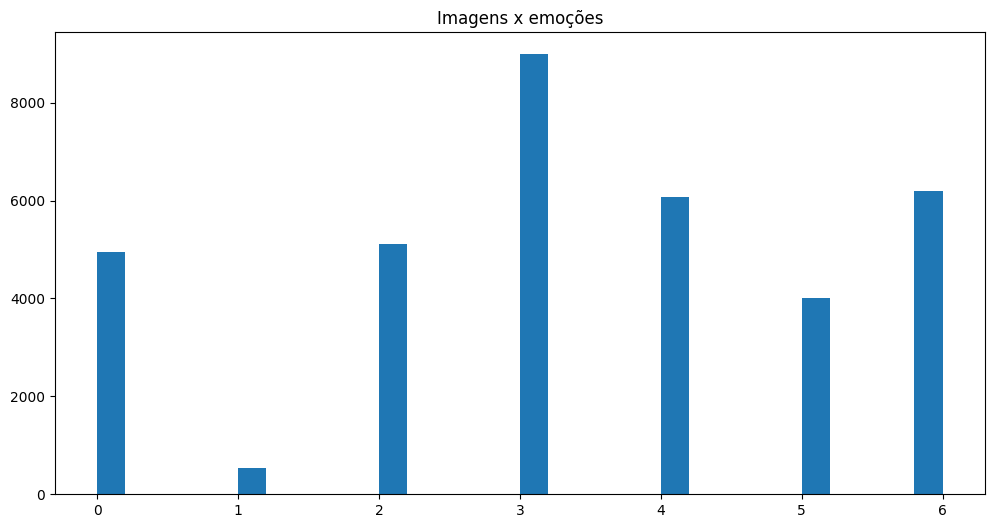

In [6]:
plt.figure(figsize=(12,6))
plt.hist(data['emotion'], bins = 30)
plt.title('Imagens x emoções')

# Classes: ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [7]:
pixels = data['pixels'].tolist()

In [8]:
def cv2_imshow(image):
    if len(image.shape) == 2:  # Se for uma imagem em escala de cinza
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Esconde os eixos
    plt.show()

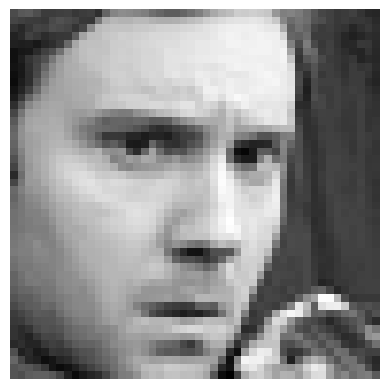

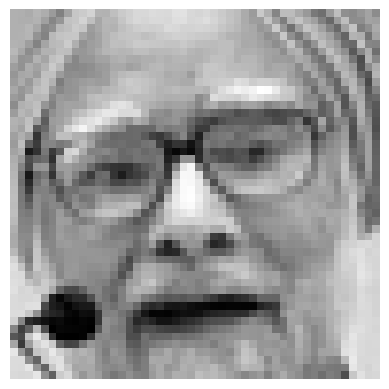

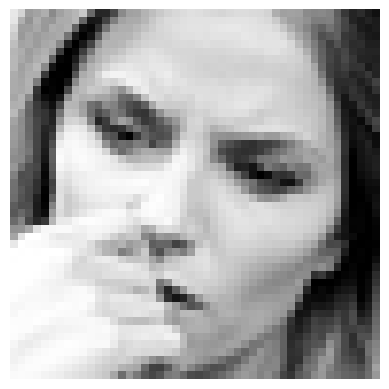

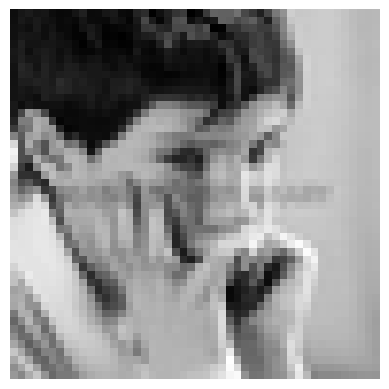

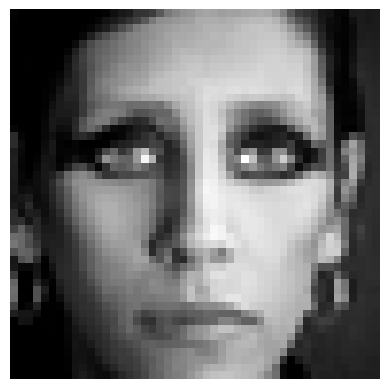

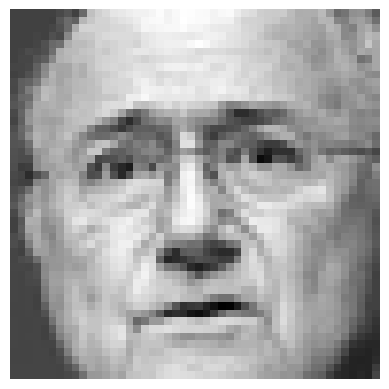

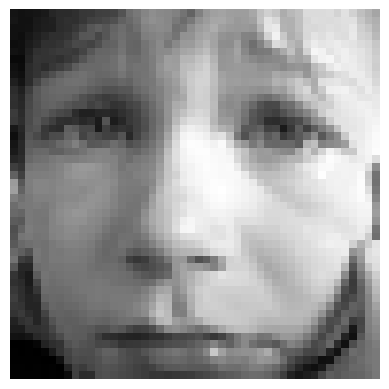

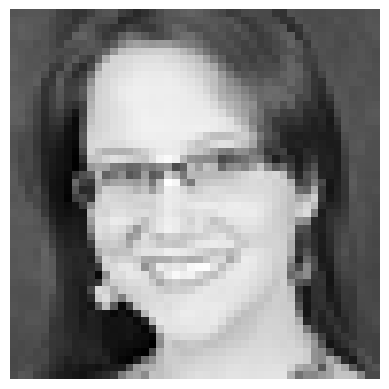

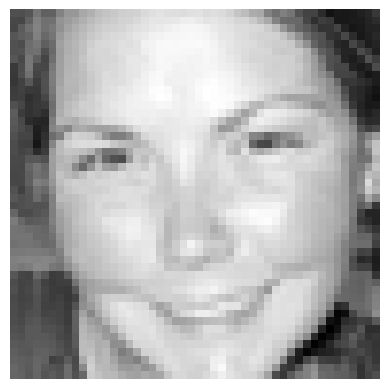

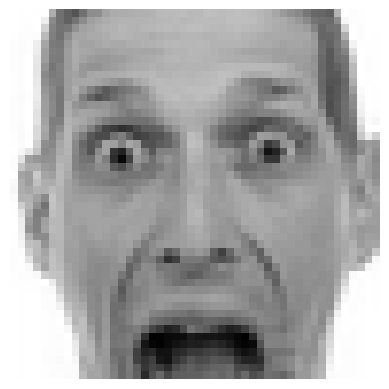

In [9]:
largura, altura = 48, 48
faces = []
amostras = 0
for pixel_sequence in pixels:
  face = [int(pixel) for pixel in pixel_sequence.split(' ')]
  face = np.asarray(face).reshape(largura, altura)
  faces.append(face)

  if (amostras < 10):
    cv2_imshow(face)
  amostras += 1

In [10]:
print('Número total de imagens no dataset: ', str(len(faces)))

Número total de imagens no dataset:  35887


In [11]:
faces = np.asarray(faces)

In [12]:
faces.shape

(35887, 48, 48)

In [13]:
faces = np.expand_dims(faces, -1)
faces.shape

(35887, 48, 48, 1)

In [14]:
def normalizar(x):
  x = x.astype('float32')
  x = x / 255.0
  return x

In [15]:
faces = normalizar(faces)

In [16]:
faces[0]

array([[[0.27450982],
        [0.3137255 ],
        [0.32156864],
        ...,
        [0.20392157],
        [0.16862746],
        [0.16078432]],

       [[0.25490198],
        [0.23921569],
        [0.22745098],
        ...,
        [0.21960784],
        [0.20392157],
        [0.17254902]],

       [[0.19607843],
        [0.16862746],
        [0.21176471],
        ...,
        [0.19215687],
        [0.21960784],
        [0.18431373]],

       ...,

       [[0.35686275],
        [0.25490198],
        [0.16470589],
        ...,
        [0.28235295],
        [0.21960784],
        [0.16862746]],

       [[0.3019608 ],
        [0.32156864],
        [0.30980393],
        ...,
        [0.4117647 ],
        [0.27450982],
        [0.18039216]],

       [[0.3019608 ],
        [0.28235295],
        [0.32941177],
        ...,
        [0.41568628],
        [0.42745098],
        [0.32156864]]], dtype=float32)

In [17]:
emocoes = pd.get_dummies(data['emotion']).values

In [18]:
emocoes[0]

array([ True, False, False, False, False, False, False])

In [19]:
import sys
!{sys.executable} -m pip install scikit-learn

In [20]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

In [21]:
X_train, X_test, y_train, y_test = train_test_split(faces, emocoes, test_size = 0.1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 41)

In [22]:
print('Número de imagens no conjunto de treinamento:', len(X_train))
print('Número de imagens no conjunto de teste:', len(X_test))
print('Número de imagens no conjunto de validação:', len(X_val))

Número de imagens no conjunto de treinamento: 29068
Número de imagens no conjunto de teste: 3589
Número de imagens no conjunto de validação: 3230


In [23]:
np.save('mod_xtest', X_test)
np.save('mod_ytest', y_test)

In [24]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width, height = 48, 48

model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3,3), activation='relu',
                 input_shape=(width, height, 1), data_format = 'channels_last',
                 kernel_regularizer = l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization (Batch  (None, 46, 46, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 128)       7

In [25]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate = 0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics = ['accuracy'])

arquivo_modelo = path_folder+'modelo_01_expressoes.keras'
arquivo_modelo_json = path_folder+'modelo_01_expressoes.json'

learning_rate_reducer = ReduceLROnPlateau(monitor='val_loss', factor = 0.9, patience=3, verbose = 1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience = 8, verbose = 1, mode = 'auto')
checkpointer = ModelCheckpoint(arquivo_modelo, monitor='val_loss', verbose = 1, save_best_only=True)

In [26]:
model_json = model.to_json()
with open(arquivo_modelo_json, 'w') as json_file:
  json_file.write(model_json)

In [27]:
history = model.fit(np.array(X_train), np.array(y_train),
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = (np.array(X_val), np.array(y_val)),
                    shuffle=True,
                    callbacks=[learning_rate_reducer, early_stopper, checkpointer])

Epoch 1/100
455/455 [==============================] - ETA: 0s - loss: 1.9696 - accuracy: 0.2150
Epoch 1: val_loss improved from inf to 1.81414, saving model to /content/gdrive/My Drive/IA/modelo_01_expressoes.keras
455/455 [==============================] - 54s 71ms/step - loss: 1.9696 - accuracy: 0.2150 - val_loss: 1.8141 - val_accuracy: 0.2594 - lr: 0.0010
Epoch 2/100
454/455 [============================>.] - ETA: 0s - loss: 1.8358 - accuracy: 0.2465
Epoch 2: val_loss did not improve from 1.81414
455/455 [==============================] - 24s 54ms/step - loss: 1.8360 - accuracy: 0.2465 - val_loss: 1.8366 - val_accuracy: 0.2594 - lr: 0.0010
Epoch 3/100
454/455 [============================>.] - ETA: 0s - loss: 1.8026 - accuracy: 0.2607
Epoch 3: val_loss did not improve from 1.81414
455/455 [==============================] - 25s 54ms/step - loss: 1.8026 - accuracy: 0.2606 - val_loss: 1.9664 - val_accuracy: 0.2594 - lr: 0.0010
Epoch 4/100
454/455 [============================>.] - ETA

In [28]:
print(history.history)

{'loss': [1.9695653915405273, 1.8359529972076416, 1.8025903701782227, 1.710710048675537, 1.5968849658966064, 1.499497413635254, 1.4507817029953003, 1.4148153066635132, 1.3560163974761963, 1.3271983861923218, 1.2924710512161255, 1.2659038305282593, 1.2387049198150635, 1.2211612462997437, 1.1974624395370483, 1.1744598150253296, 1.1512411832809448, 1.1234933137893677, 1.0982024669647217, 1.0780946016311646, 1.0638190507888794, 1.0402384996414185, 1.0178978443145752, 0.9934276342391968, 0.9757885336875916, 0.9502553343772888, 0.9425562620162964, 0.9123761653900146, 0.8860321044921875, 0.8709216713905334, 0.8554278016090393, 0.8381246328353882, 0.8097876310348511, 0.799717128276825, 0.7750648856163025, 0.7489813566207886, 0.7335348129272461, 0.7079173922538757], 'accuracy': [0.2149786651134491, 0.2464909851551056, 0.2605958580970764, 0.3093779981136322, 0.36913445591926575, 0.4080432057380676, 0.4354272782802582, 0.45985275506973267, 0.48441585898399353, 0.49938076734542847, 0.5100454092025

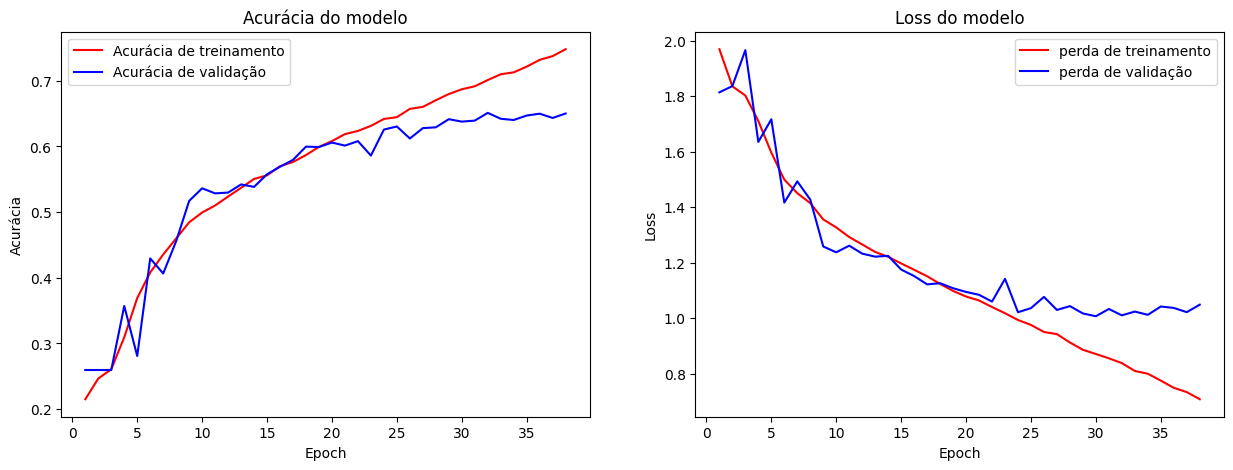

In [29]:
def plota_historico_modelo(historico_modelo):
  fig, axs = plt.subplots(1, 2, figsize=(15,5))
  axs[0].plot(range(1, len(historico_modelo.history['accuracy']) + 1), historico_modelo.history['accuracy'], 'r')
  axs[0].plot(range(1, len(historico_modelo.history['val_accuracy']) + 1), historico_modelo.history['val_accuracy'], 'b')
  axs[0].set_title('Acurácia do modelo')
  axs[0].set_ylabel('Acurácia')
  axs[0].set_xlabel('Epoch')
  #axs[0].set_xticks(np.arange(1, len(historico_modelo.history['accuracy']) + 1), len(historico_modelo.history['accuracy']) / 10)
  axs[0].legend(['Acurácia de treinamento', 'Acurácia de validação'], loc = 'best')

  axs[1].plot(range(1, len(historico_modelo.history['loss']) + 1), historico_modelo.history['loss'], 'r')
  axs[1].plot(range(1, len(historico_modelo.history['val_loss']) + 1), historico_modelo.history['val_loss'], 'b')
  axs[1].set_title('Loss do modelo')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epoch')
  #axs[1].set_xticks(np.arange(1, len(historico_modelo.history['loss']) + 1), len(historico_modelo.history['loss']) / 10)
  axs[1].legend(['perda de treinamento', 'perda de validação'], loc = 'best')
  fig.savefig('historico_modelo_mod01.png')

plota_historico_modelo(history)

In [30]:
scores = model.evaluate(np.array(X_test), np.array(y_test), batch_size = batch_size)

57/57 [==============================] - 1s 21ms/step - loss: 1.0659 - accuracy: 0.6330


In [31]:
scores

[1.0659294128417969, 0.6330454349517822]

In [32]:
print('Acurácia: ' + str(scores[1]))
print('Erro: ' + str(scores[0]))

Acurácia: 0.6330454349517822
Erro: 1.0659294128417969


In [33]:
true_y = []
pred_y = []
x = np.load('mod_xtest.npy')
y = np.load('mod_ytest.npy')

In [34]:
x[0]

array([[[0.5568628 ],
        [0.5803922 ],
        [0.59607846],
        ...,
        [0.3529412 ],
        [0.3529412 ],
        [0.3647059 ]],

       [[0.5568628 ],
        [0.5764706 ],
        [0.5921569 ],
        ...,
        [0.33333334],
        [0.36078432],
        [0.40392157]],

       [[0.5529412 ],
        [0.5686275 ],
        [0.5921569 ],
        ...,
        [0.3372549 ],
        [0.32156864],
        [0.37254903]],

       ...,

       [[0.0627451 ],
        [0.08235294],
        [0.07058824],
        ...,
        [0.08235294],
        [0.09019608],
        [0.11372549]],

       [[0.05490196],
        [0.0627451 ],
        [0.05490196],
        ...,
        [0.07450981],
        [0.07843138],
        [0.09803922]],

       [[0.04705882],
        [0.04705882],
        [0.04705882],
        ...,
        [0.06666667],
        [0.07450981],
        [0.09411765]]], dtype=float32)

In [35]:
y[0]

array([False, False, False,  True, False, False, False])

In [36]:
json_file = open(arquivo_modelo_json, 'r')
loaded_model_json = json_file.read()
json_file.close()

In [37]:
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(arquivo_modelo)

In [38]:
y_pred = loaded_model.predict(x)

113/113 [==============================] - 2s 6ms/step


In [39]:
y_pred[0]

array([8.4976244e-05, 5.1112897e-10, 1.2011822e-04, 9.9387771e-01,
       2.9593398e-04, 8.7064554e-06, 5.6125442e-03], dtype=float32)

In [40]:
yp = y_pred.tolist()
yt = y.tolist()
count = 0

In [41]:
len(y)

3589

In [42]:
for i in range(len(y)):
  yy = max(yp[i])
  yyt = max(yt[i])
  pred_y.append(yp[i].index(yy))
  true_y.append(yt[i].index(yyt))
  if (yp[i].index(yy) == yt[i].index(yyt)):
    count += 1

acc = (count / len(y)) * 100

In [43]:
print('Acurácia no conjunto de teste: ' + str(acc))

Acurácia no conjunto de teste: 61.93925884647534


In [44]:
np.save('truey_mod01', true_y)
np.save('predy_mod01', pred_y)

In [45]:
from sklearn.metrics import confusion_matrix

In [46]:
y_true = np.load('truey_mod01.npy')
y_pred = np.load('predy_mod01.npy')

In [47]:
cm = confusion_matrix(y_true, y_pred)
expressoes = ['Raiva', 'Nojo', 'Medo', 'Feliz', 'Triste', 'Surpreso', 'Neutro']
titulo = 'Matriz de Confusão'
print(cm)

[[212   1  49  33 114  11  78]
 [ 18  17   6   2   7   1   1]
 [ 42   7 213  35 168  31  49]
 [ 15   0  17 776  32  15  26]
 [ 28   0  35  39 388   0  98]
 [  8   0  87  41   8 254  16]
 [ 17   0  26  69 129   7 363]]


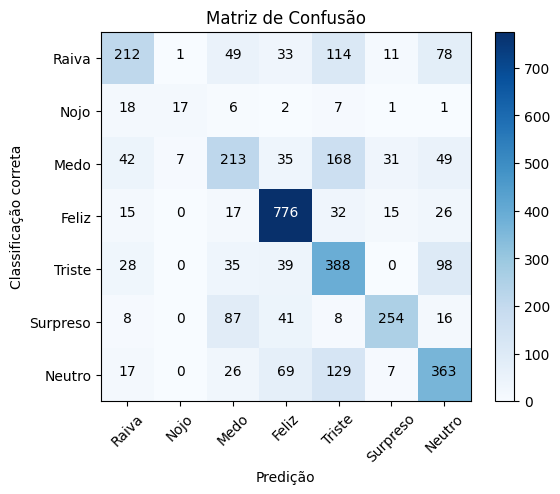

In [48]:
import itertools
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(titulo)
plt.colorbar()
tick_marks = np.arange(len(expressoes))
plt.xticks(tick_marks, expressoes, rotation = 45)
plt.yticks(tick_marks, expressoes)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i,j] > thresh else 'black')

plt.ylabel('Classificação correta')
plt.xlabel('Predição')
plt.savefig('matriz_confusao_mod01.png')

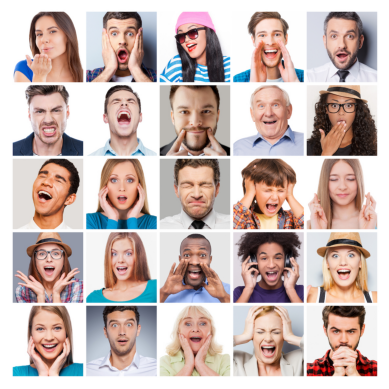

In [49]:
imagem = cv2.imread(path_folder+'testes/teste03.jpg')
cv2_imshow(imagem)

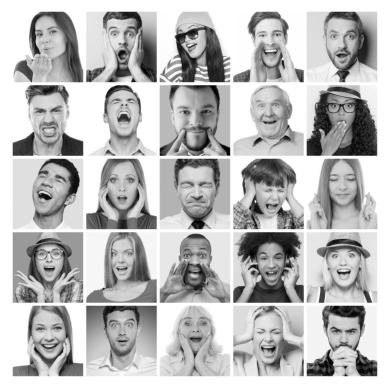

In [50]:
original = imagem.copy()
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

In [51]:
face_cascade = cv2.CascadeClassifier(path_folder+'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, 1.1, 3)

In [52]:
faces

array([[  57,   30,  119,  119],
       [ 760,   31,  126,  126],
       [ 287,   21,  138,  138],
       [ 978,   30,  145,  145],
       [ 304,  252,  112,  112],
       [ 757,  256,  125,  125],
       [ 991,  264,  109,  109],
       [  53,  271,  138,  138],
       [ 499,  257,  179,  179],
       [ 993,  493,  122,  122],
       [ 284,  490,  142,  142],
       [ 522,  503,  141,  141],
       [ 300,  733,  107,  107],
       [  72,  739,  105,  105],
       [ 524,  732,  132,  132],
       [ 770,  744,  114,  114],
       [ 994,  738,  123,  123],
       [ 301,  958,  111,  111],
       [  51,  957,  145,  145],
       [ 523,  943,  134,  134],
       [ 988,  969,  140,  140],
       [ 769,  985,  102,  102],
       [ 996, 1024,  121,  121]], dtype=int32)

1/1 [==============================] - 0s 16ms/step


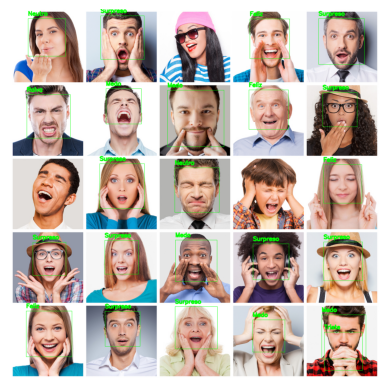

In [53]:
for (x, y, w, h) in faces:
  cv2.rectangle(original, (x, y), (x + w, y + h), (0, 255, 0), 1)
  roi_gray = gray[y:y + h, x:x + w]
  roi_gray = roi_gray.astype('float') / 255.0
  cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
  prediction = loaded_model.predict(cropped_img)[0]
  cv2.putText(original, expressoes[int(np.argmax(prediction))], (x, y - 10),
              cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)

cv2_imshow(original)

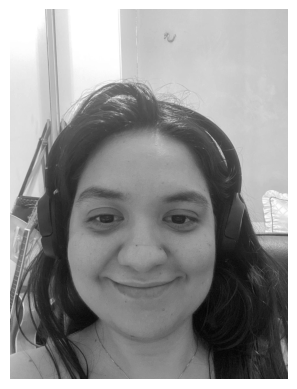

In [57]:
imagem2 = cv2.imread('sarahfoto1.jpeg')
original = imagem2.copy()
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

In [58]:
face_cascade = cv2.CascadeClassifier(path_folder+'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, 1.1, 3)
faces

array([[120, 455, 674, 674]], dtype=int32)

1/1 [==============================] - 0s 30ms/step


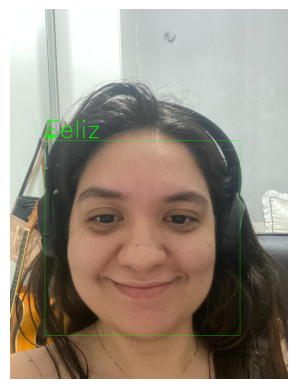

In [60]:
for (x, y, w, h) in faces:
  cv2.rectangle(original, (x, y), (x + w, y + h), (0, 255, 0), 1)
  roi_gray = gray[y:y + h, x:x + w]
  roi_gray = roi_gray.astype('float') / 255.0
  cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
  prediction = loaded_model.predict(cropped_img)[0]
  cv2.putText(original, expressoes[int(np.argmax(prediction))], (x, y - 10),
              cv2.FONT_HERSHEY_SIMPLEX, 2.8, (0, 255, 0), 2, cv2.LINE_AA)

cv2_imshow(original)

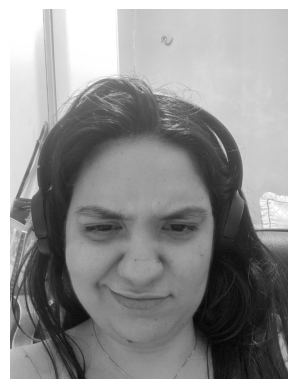

In [61]:
imagem2 = cv2.imread('sarahfoto2.jpeg')
original = imagem2.copy()
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

In [62]:
face_cascade = cv2.CascadeClassifier(path_folder+'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, 1.1, 3)
faces

array([[118, 507, 651, 651],
       [830, 687,  74,  74]], dtype=int32)

1/1 [==============================] - 0s 26ms/step


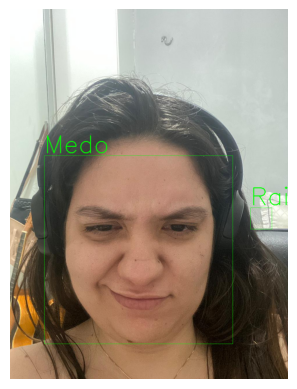

In [63]:
for (x, y, w, h) in faces:
  cv2.rectangle(original, (x, y), (x + w, y + h), (0, 255, 0), 1)
  roi_gray = gray[y:y + h, x:x + w]
  roi_gray = roi_gray.astype('float') / 255.0
  cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
  prediction = loaded_model.predict(cropped_img)[0]
  cv2.putText(original, expressoes[int(np.argmax(prediction))], (x, y - 10),
              cv2.FONT_HERSHEY_SIMPLEX, 2.8, (0, 255, 0), 2, cv2.LINE_AA)

cv2_imshow(original)